In [1]:
# load libraries and set plot parameters
import numpy as np
from Stuff import usefulfunctions as uf
    
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = set(['png', 'retina', 'svg'])

In [2]:
# Matplotlib settings
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

plt.style.use('revtex')
textwidth = 510
linewidth = 246

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['o', 's', '^', 'v', 'd', 'h', '<', '>', 'x', '8', 'p', '*', '1', '2', '3', '4', '+', 'P', 'H', 'D']

In [3]:
# Imports
import os
import time
import shutil
import drprobe as drp
import hyperspy.api as hs
from Stuff import colors as cc
import colorcet
from collections import OrderedDict
from matplotlib.colors import LogNorm
from scipy import constants
from skimage.restoration import unwrap_phase
from matplotlib.colors import LightSource, Normalize
from Stuff import fitfunctions as ff
# from matplotlib import colors
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg

from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from Stuff import fitfunctions as ff

In [4]:
from multiprocessing import Pool
cpu_count = 40

# Functions

In [5]:
def add_colorwheel(axis, cmap=None, loc=1):
    """Add a colorwheel to the axis on the upper right corner.

        Parameters
        ----------
        axis : :class:`~matplotlib.axes.AxesSubplot`
            Axis to which the colorwheel is added.

        Returns
        -------
        axis : :class:`~matplotlib.axes.AxesSubplot`
            The same axis which was given to this function is returned.

    """
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    inset_axes = inset_axes(axis, width=0.25, height=0.25, loc=loc)
    inset_axes.axis('off')  # TODO: Matplotlib 2.0 uses False! Search 'off' to change everywhere!
    if cmap is None:
        cmap = colors.CMAP_CIRCULAR_DEFAULT
    #bgcolor = None#axis.get_facecolor() TODO: Activate for matplotlib 2.0!
    return cmap.plot_colorwheel(size=100, axis=inset_axes, alpha=0, arrows=False) 

In [6]:
def convolve_2d(arr1, arr2):
    """
    Returns the convolution between arr1 and arr2. The convolution is performed via multiplication in Fourier space.
    """
    fft_arr1 = np.fft.fft2(arr1)
    fft_arr2 = np.fft.fft2(arr2)
    
    return np.real(np.fft.ifft2(fft_arr1 * fft_arr2))

In [7]:
def int_2d_fourier(arr, sampling):
    freqs = uf.freq_array(arr.shape, sampling)

    k_sq = np.where(freqs != 0, freqs**2, 0.0001)
    k = np.meshgrid(np.fft.fftfreq(arr.shape[0], sampling[0]), np.fft.fftfreq(arr.shape[1], sampling[1]))

    v_int_x = np.real(np.fft.ifft2((np.fft.fft2(np.real(arr)) * k[0]) / (2*np.pi * 1j * k_sq))) #/ np.sqrt(arr.shape[0])
    v_int_y = np.real(np.fft.ifft2((np.fft.fft2(np.imag(arr)) * k[1]) / (2*np.pi * 1j * k_sq))) #/ np.sqrt(arr.shape[1])

    v_int_fs = v_int_x + v_int_y
    return v_int_fs #/ 2

In [8]:
def disk_mask(radius):
    freqs = uf.freq_array((ny, nx), (b / ny, a / nx))
    inner_disk = radius / 1000 / wavelength
    return freqs, inner_disk

# Generating phase gratings (celslc)

In [9]:
# Lattice constants
a, b, c = np.genfromtxt('cel/STO_001_4x4_DWF-Abramov.cel', skip_header=1, skip_footer=1, usecols=(1, 2, 3))[0]

# Number of sampling points along x and y
nx = int(uf.find_closest_int_with_low_prime_factors(np.round(2 * a * 150, 0)))
ny = int(uf.find_closest_int_with_low_prime_factors(np.round(2 * b * 150, 0)))

scan_shape = (40, 40)
sampling = np.array([b / 4, a / 4]) / np.asarray(scan_shape)

print('scan sampling rate: {:.4f} nm/px'.format(sampling[0]))

scan sampling rate: 0.0098 nm/px


In [10]:
# constants
h = constants.h
e = constants.elementary_charge
v = uf.electron_velocity(300)

C_E = uf.interaction_constant(300)

pre_factor = v * h / e

In [11]:
# Calculate Mean inner potential from neutral scattering factors
volume_uc = (a / 4 * 1e-9) * (b / 4 * 1e-9) * (c * 1e-9)

mip_sto = constants.h**2 / (2 * constants.pi * constants.electron_mass * e * volume_uc)
f_el_Sr = 13.0052 * 1e-10
f_el_Ti = 8.7270 * 1e-10
f_el_O = 1.9839 * 1e-10
mip_sto *= (f_el_Sr + f_el_Ti + 3 * f_el_O)

print('Mean inner potential of SrTiO3: {:.2f} V'.format(mip_sto))

Mean inner potential of SrTiO3: 22.26 V


## For dynamics (no frozen lattice)

In [82]:
# Execute celslc (without Frozen lattice, but DWF and Absorption)
drp.celslc("cel/STO_001_4x4_DWF-Abramov.cel", 'slc/DWF_Weickenmeier/STO_300kV_bin2', 
           nx=nx/2, ny=ny/2, nz=2, ht=300, output=False, absorb=True, dwf=True, fl=False, pot=True)

# Convolution kernels (apertures)

In [12]:
# Apertures and Probes
fa = uf.freq_array(scan_shape, sampling)
ap_radius = uf.mrad_to_reciprocal_nm(25, 300)

# Aperture - B(k)
ap_1 = uf.aperture_function(fa, ap_radius, ap_radius*0.02)
ap_2 = uf.aperture_function(fa, ap_radius, ap_radius*0.1)

# Probe B(r) - normed to \sum B(r) = 1
i_probe_1 = np.real(np.fft.ifft2(ap_1))
i_probe_1 /= np.sum(i_probe_1)

# Probe B^2(r) - normed to \sum B^2(r) = 1
i_probe_2 = np.real(np.fft.ifft2(ap_2) ** 2)
i_probe_2 /= np.sum(i_probe_2)

# Potentials from Multislice (scattering factors)

In [22]:
# Potentials
pot_1 = np.fromfile('slc/DWF_Weickenmeier/STO_300kV_bin3_001.pot', dtype='complex64').reshape((int(nx/3), int(ny/3)))
pot_2 = np.fromfile('slc/DWF_Weickenmeier/STO_300kV_bin3_002.pot', dtype='complex64').reshape((int(nx/3), int(ny/3)))
pot = (pot_1 + pot_2) / 2
pot_uc = np.real(pot)[:int(scan_shape[0]), :int(scan_shape[1])] # projected in units of Volt
pot_uc_int = pot_uc * c # projected * thickness in units of Volt*nm
e_uc_int = -np.gradient(pot_uc_int, sampling[1], axis=1) - 1j * np.gradient(pot_uc_int, sampling[0], axis=0)

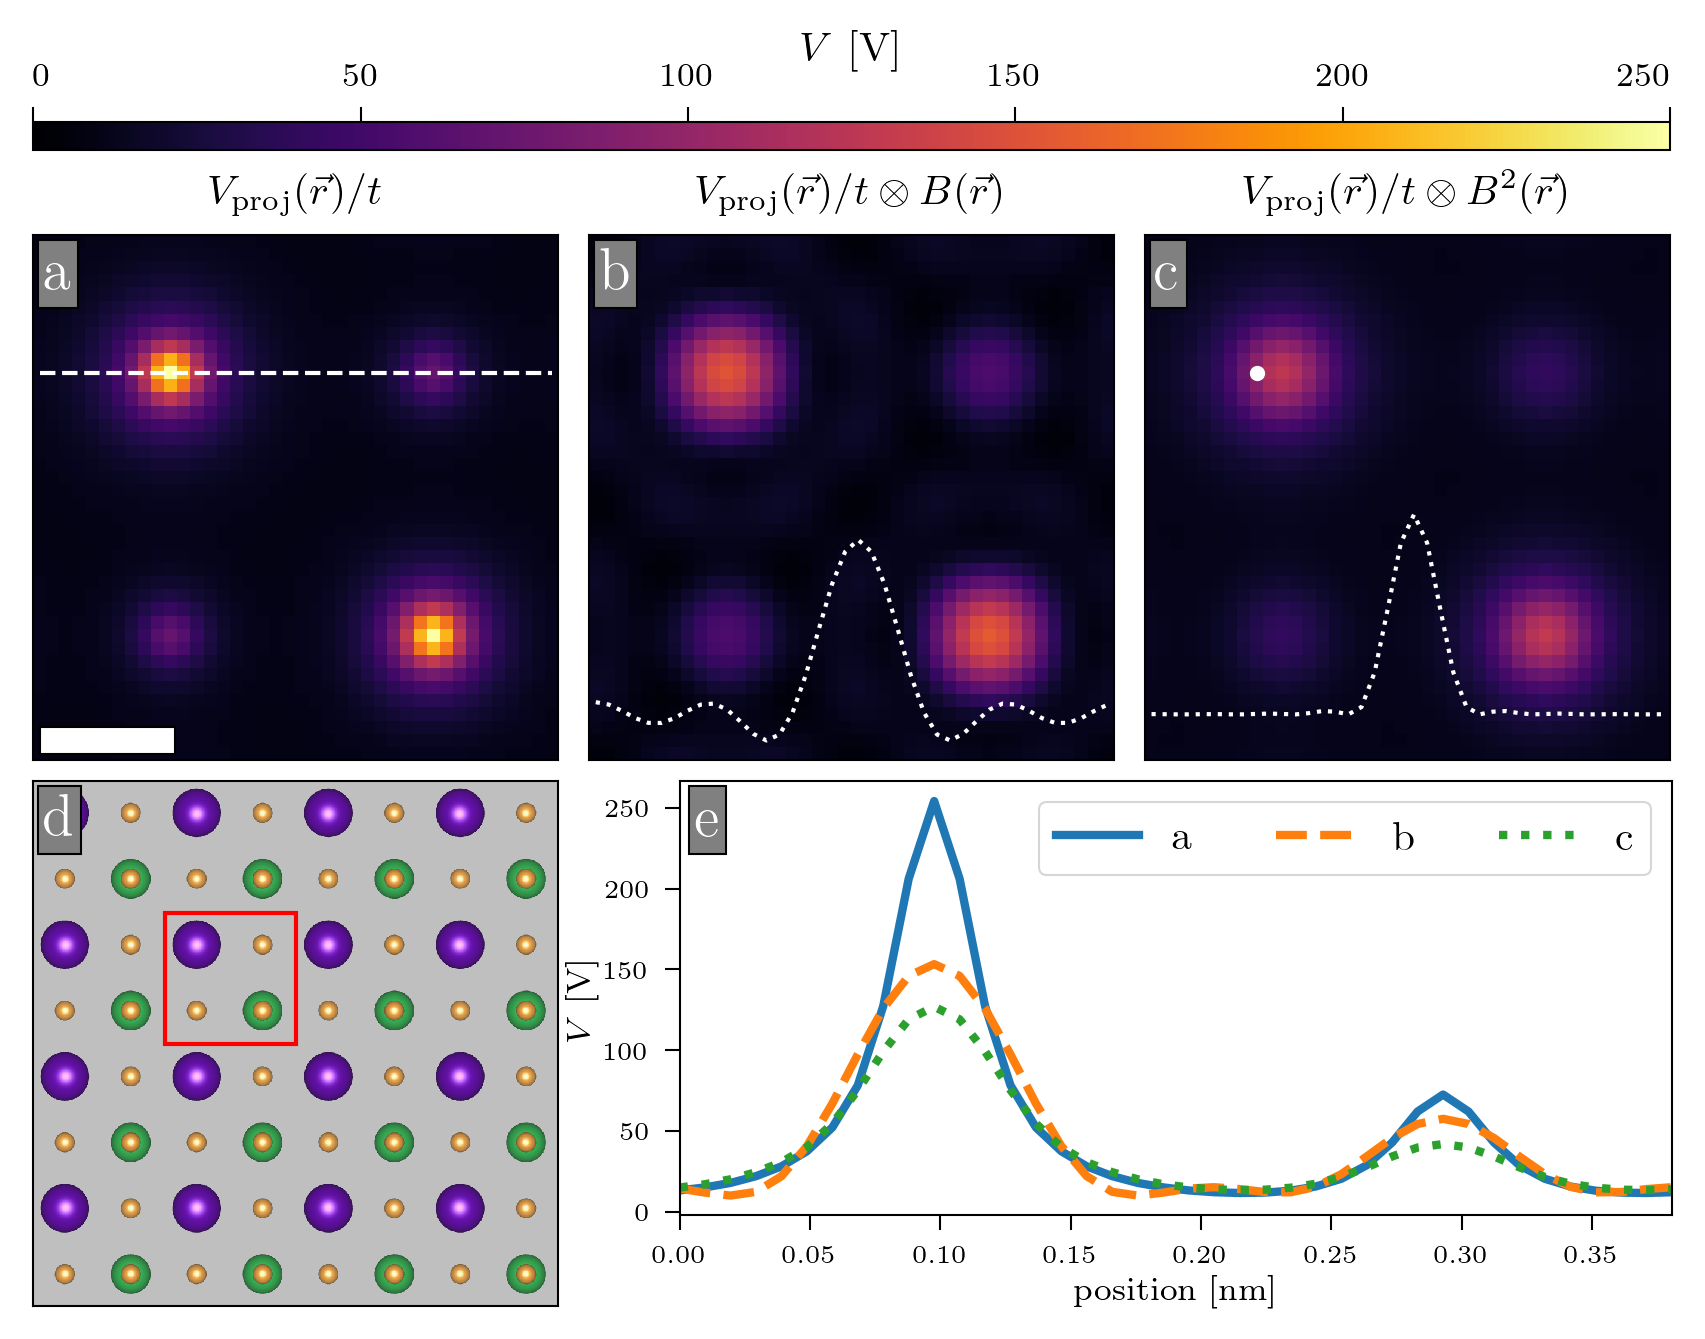

In [86]:
# New plot with kernels
fig = plt.figure(constrained_layout=False, figsize=uf.figsize(1, 0.67, textwidth))

gs = GridSpec(12, 18, figure=fig)
axs = []
axs.append(fig.add_subplot(gs[:6, :6]))
axs.append(fig.add_subplot(gs[:6, 6:12]))
axs.append(fig.add_subplot(gs[:6, 12:]))
axs.append(fig.add_subplot(gs[6:, 0:6]))
axs.append(fig.add_subplot(gs[6:11, 7:]))

plt.subplots_adjust(wspace=0.4, hspace=0.3)

cmap = 'inferno'
clim = (0, 250)

img = mpimg.imread('STO.png')
im0 = axs[0].imshow(pot_uc_int / c, clim=clim, cmap=cmap)
axs[0].hlines(10, 0, 39, color='white', linestyle='dashed', lw=1)
im1 = axs[1].imshow(convolve_2d(pot_uc_int, i_probe_1) / c, clim=clim, cmap=cmap)
im2 = axs[2].imshow(convolve_2d(pot_uc_int, i_probe_2) / c, clim=clim, cmap=cmap)
im3 = axs[3].imshow(img)

axs[1].plot(np.fft.fftshift(i_probe_1)[20, :] * (-300) + 36, color='white', ls=':')
axs[2].plot(np.fft.fftshift(i_probe_2)[20, :] * (-300) + 36, color='white', ls=':')

r = Rectangle((img.shape[1] / 4, img.shape[0] / 4), img.shape[1] / 4, img.shape[0] / 4, 
              fill=False, color='red', lw=1)
axs[3].add_patch(r)
axs[4].plot(np.arange(0, 40, 1) * sampling[1], pot_uc_int[10, :] / c, # / np.max(pot_uc_int[10, :]), 
            #label=r'$V_{\mathrm{proj}}(\vec{r}) / t(\vec{r})$', 
            label='a',
            ls='solid', lw=2)
axs[4].plot(np.arange(0, 40, 1) * sampling[1], convolve_2d(pot_uc_int, i_probe_1)[10, :] / c, # / np.max(convolve_2d(pot_uc_int, i_probe_1)[10, :]), 
            #label=r'$V_{\mathrm{proj}}(\vec{r})  / t(\vec{r})\otimes B(\vec{r})$', 
            label='b',
            ls='dashed', lw=2)
axs[4].plot(np.arange(0, 40, 1) * sampling[1], convolve_2d(pot_uc_int, i_probe_2)[10, :] / c, # / np.max(convolve_2d(pot_uc_int, i_probe_2)[10, :]), 
            #label=r'$V_{\mathrm{proj}}(\vec{r})  / t(\vec{r})\otimes B^2(\vec{r})$', 
            label='c',
            ls='dotted', lw=2)
#ppp = np.angle(np.exp(1j * C_E * convolve_2d(pot_uc_int, i_probe_1)*1e-9)) / (c*C_E*1e-9)
#axs[4].plot(np.arange(0, 40, 1) * sampling[1], ppp[10, :], label=r'test', ls='dotted', color='black', lw=3)
axs[4].set_xlim(0, 39*sampling[1])
axs[4].set_xlabel('position [nm]', labelpad=2, fontsize=8)
axs[4].set_ylabel(r'$V$ [V]', labelpad=1.5, fontsize=8)
axs[4].legend(fontsize=10, ncol=3)
axs[4].tick_params(axis="both", labelsize=6)

axs[0].set_title(r'$V_{\mathrm{proj}}(\vec{r}) / t$')
axs[1].set_title(r'$V_{\mathrm{proj}}(\vec{r}) / t\otimes B(\vec{r})$')
axs[2].set_title(r'$V_{\mathrm{proj}}(\vec{r}) / t\otimes B^2(\vec{r})$')

uf.scalebar(axs[0], 0.1, sampling[0])
uf.scalebar(axs[1], 0, sampling[0])
uf.scalebar(axs[2], 0, sampling[0])
uf.scalebar(axs[3], 0, sampling[0])

axs[2].scatter(8, 10, color='white', s=10, marker='o')

# Colorbar
p0 = axs[0].get_position().get_points().flatten()
p1 = axs[2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.94, p1[2]-p0[0], 0.02])
cb1 = plt.colorbar(im0, cax=ax_cbar, orientation='horizontal')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')
cb1.set_ticks([0, 50, 100, 150, 200, 250])
tl = cb1.ax.get_xticklabels()
tl[0].set_horizontalalignment('left')
tl[-1].set_horizontalalignment('right')
cb1.set_label(r'$V$ [V]', labelpad=0)

bbox_props = dict(boxstyle="square,pad=0.1", fc="gray", ec="black", lw=0.5, alpha=1)
for i, s in enumerate(['a', 'b', 'c', 'd']):
    axs[i].annotate(s, (0.02, 0.98), xycoords='axes fraction', color='white', va='top', 
                fontweight='bold', fontsize=14, bbox=bbox_props)
axs[4].annotate('e', (0.015, 0.975), xycoords='axes fraction', color='white', va='top', 
                fontweight='bold', fontsize=14, bbox=bbox_props);

uf.savefig('Images/Potentials_convolutions', formats=['png'], bbox_inches='tight', dpi=300)

# Images for presantations

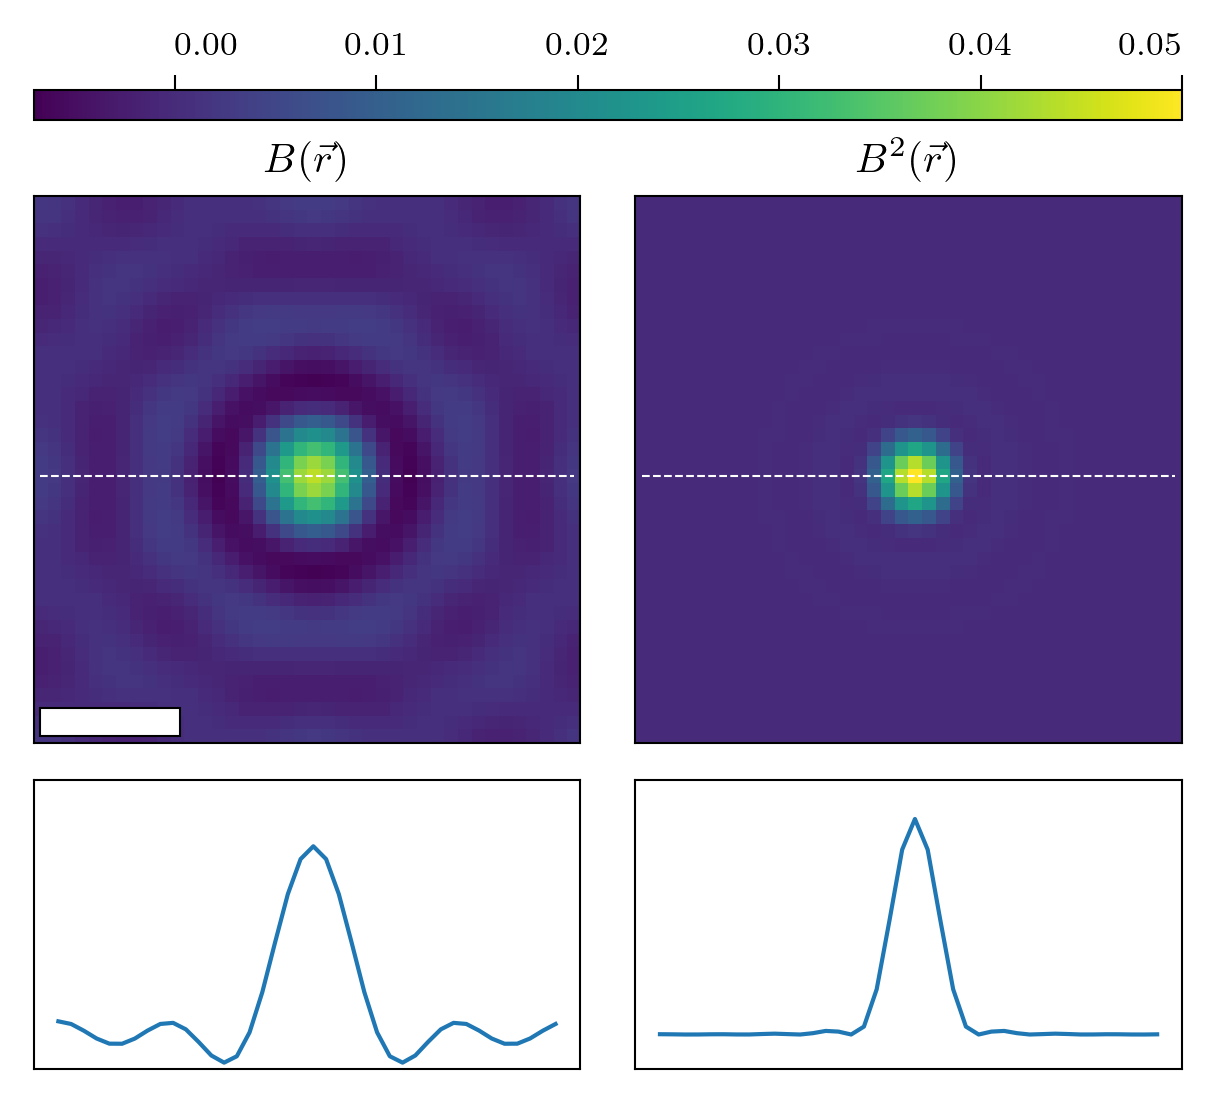

In [87]:
# Plot of convolution kernels
fig = plt.figure(constrained_layout=False, figsize=uf.figsize(0.7, 0.8, textwidth))

gs = GridSpec(3, 2, figure=fig)
axs = []
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[2, 0]))
axs.append(fig.add_subplot(gs[2, 1]))

plt.subplots_adjust(wspace=0.1, hspace=0.05)

im = axs[0].imshow(np.fft.fftshift(i_probe_1), clim=(-0.007, 0.05), cmap='viridis')
im = axs[1].imshow(np.fft.fftshift(i_probe_2), clim=(-0.007, 0.05), cmap='viridis')
axs[0].set_title(r'$B(\vec{r})$')
axs[1].set_title(r'$B^2(\vec{r})$')
uf.scalebar(axs[0], 0.1, sampling[0])
uf.scalebar(axs[1], 0., sampling[0])

axs[0].plot([0, 39], [20, 20], linestyle='dashed', color='white', lw=0.5)
axs[1].plot([0, 39], [20, 20], linestyle='dashed', color='white', lw=0.5)

# Colorbar
p0 = axs[0].get_position().get_points().flatten()
p1 = axs[1].get_position().get_points().flatten()

ax_cbar = fig.add_axes([p0[0], 0.925, p1[2]-p0[0], 0.025])
cb1 = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')

cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

#cb1.set_ticks([0, 20, 40, 60, 80, 100])

tl = cb1.ax.get_xticklabels()
tl[0].set_horizontalalignment('left')
tl[-1].set_horizontalalignment('right')

#cb1.set_label(r'$V$ [Vnm]', labelpad=0)



axs[2].plot(np.arange(0, 40, 1) * sampling[0], np.fft.fftshift(i_probe_1)[20, :])
axs[3].plot(np.arange(0, 40, 1) * sampling[0], np.fft.fftshift(i_probe_2)[20, :])
axs[2].set_xticks([])
axs[3].set_xticks([])
axs[2].set_ylim(-0.008, 0.06)
axs[3].set_ylim(-0.008, 0.06)
axs[2].set_yticks([])
axs[3].set_yticks([]);

uf.savefig('Images/extra/Convolution_kernels', formats=['png'], bbox_inches='tight', dpi=300)

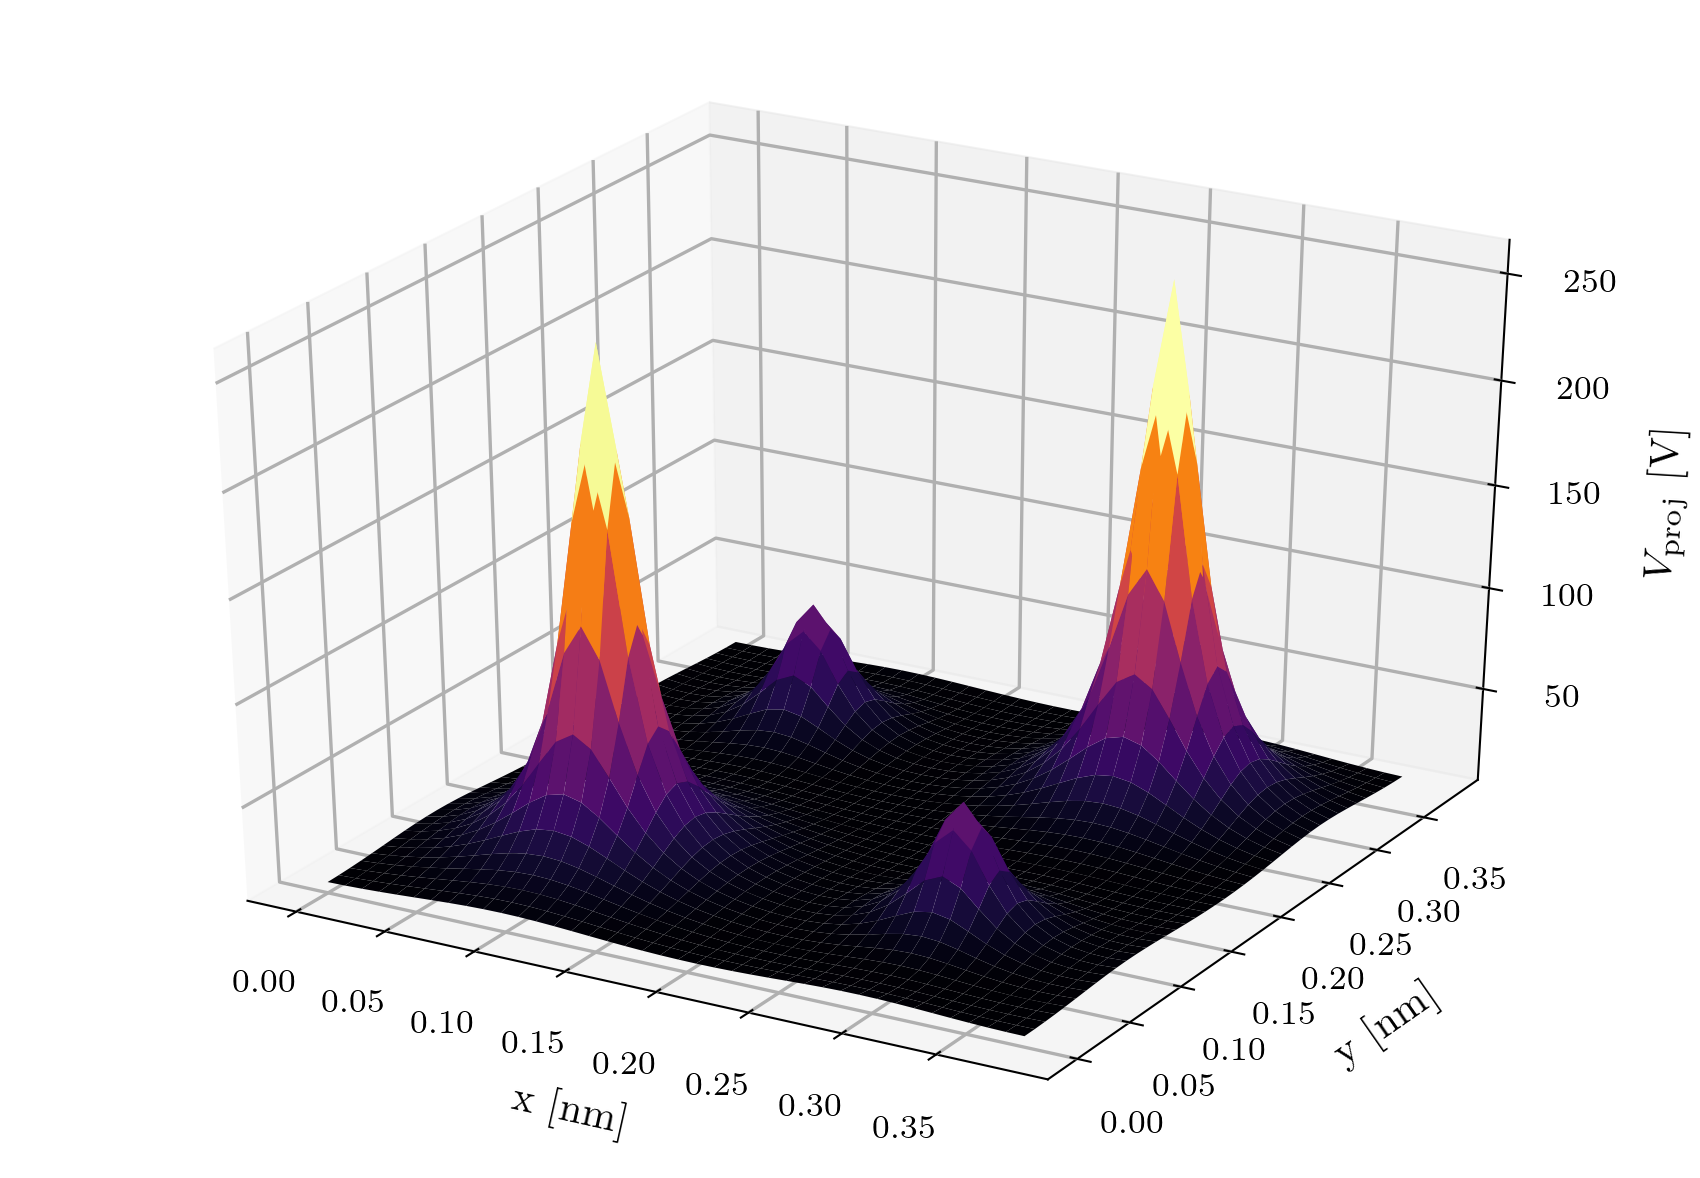

In [88]:
# 3D plot of potential
x = np.arange(0, 40, 1) * sampling[0]
y = np.arange(0, 40, 1) * sampling[0]

X, Y = np.meshgrid(x, y)
Z = np.abs(pot_uc)

fig = plt.figure(figsize=uf.figsize(1, 0.7, textwidth))
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, -constants.elementary_charge*Z, 100, cmap='nipy_spectral')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='inferno', edgecolor='none')
ax.set_xlabel('x [nm]')
ax.set_ylabel('y [nm]')
ax.set_zlabel(r'$V_{\mathrm{proj}}$ [V]');
#ax.view_init(30, 35)

uf.savefig('Images/extra/Potential_3D', formats=['png'], bbox_inches='tight', dpi=300)

# Unused images

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=uf.figsize(0.8, textwidth=textwidth))
axs.plot(np.fft.fftshift(i_probe_1)[20, :], label=r'$B(\vec{r})$')
axs.plot(np.fft.fftshift(i_probe_2)[20, :], label=r'$B^2(\vec{r})$')
axs.plot(pot_uc_int[10, :] * C_E * 1e-9, label='pot')
axs.plot(convolve_2d(pot_uc_int, i_probe_1)[10, :] * C_E * 1e-9, label='pot conv')
axs.legend()

#axs.set_ylabel('')

In [ ]:
# Plot potentials
fig, axs = plt.subplots(1, 3, figsize=uf.figsize(0.8, 0.4, textwidth))
plt.subplots_adjust(wspace=0.1)
cmap = 'inferno'
clim = (0, 100)

axs = axs.ravel()
im = axs[0].imshow(pot_uc_int, clim=clim, cmap=cmap)
axs[1].imshow(convolve_2d(pot_uc_int, i_probe_1), clim=clim, cmap=cmap)
axs[2].imshow(convolve_2d(pot_uc_int, i_probe_2), clim=clim, cmap=cmap)

axs[0].set_title(r'$V_{\mathrm{int}}(\vec{r})$')
axs[1].set_title(r'$V_{\mathrm{int}}(\vec{r}) \otimes B(\vec{r})$')
axs[2].set_title(r'$V_{\mathrm{int}}(\vec{r}) \otimes B^2(\vec{r})$')

#axs[2].imshow(Sr_map_rgb, interpolation=None, extent=[0, scan_shape[1], scan_shape[0], 0])
#axs[2].imshow(Ti_map_rgb, interpolation=None, extent=[0, scan_shape[1], scan_shape[0], 0])
#axs[2].imshow(O_map_rgb,  interpolation=None, extent=[0, scan_shape[1], scan_shape[0], 0])


axs[2].set_xlim(0, scan_shape[1]-1)
axs[2].set_ylim(scan_shape[0]-1, 0)

uf.scalebar(axs[0], 0.1, sampling[0])
uf.scalebar(axs[1], 0, sampling[0])
uf.scalebar(axs[2], 0, sampling[0])


# Colorbar
p0 = axs[0].get_position().get_points().flatten()
p1 = axs[2].get_position().get_points().flatten()

ax_cbar = fig.add_axes([p0[0], 0.92, p1[2]-p0[0], 0.04])
cb1 = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')

cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb1.set_ticks([0, 20, 40, 60, 80, 100])

tl = cb1.ax.get_xticklabels()
tl[0].set_horizontalalignment('left')
tl[-1].set_horizontalalignment('right')

cb1.set_label(r'$V$ [Vnm]', labelpad=0)

#uf.savefig('Images/Potentials_convolutions', formats=['png', 'pdf'], bbox_inches='tight', dpi=300)

In [ ]:
# Line scans
fig, axs = plt.subplots(1, 2, figsize=uf.figsize(0.9, 0.5, textwidth=textwidth))
axs[0].plot(pot_uc_int[10, :], label=r'$V_{\mathrm{int}}(\vec{r})$')
axs[0].plot(convolve_2d(pot_uc_int, i_probe_1)[10, :], label=r'$V_{\mathrm{int}}(\vec{r}) \otimes B(\vec{r})$')
axs[0].plot(convolve_2d(pot_uc_int, i_probe_2)[10, :], label=r'$V_{\mathrm{int}}(\vec{r}) \otimes B^2(\vec{r})$')

axs[1].plot(pot_uc_int[10, :] / np.max(pot_uc_int[10, :]),
            label=r'$V_{\mathrm{int}}(\vec{r})$')
axs[1].plot(convolve_2d(pot_uc_int, i_probe_1)[10, :] / np.max(convolve_2d(pot_uc_int, i_probe_1)[10, :]), 
            label=r'$V_{\mathrm{int}}(\vec{r}) \otimes B(\vec{r})$')
axs[1].plot(convolve_2d(pot_uc_int, i_probe_2)[10, :] / np.max(convolve_2d(pot_uc_int, i_probe_2)[10, :]), 
            label=r'$V_{\mathrm{int}}(\vec{r}) \otimes B^2(\vec{r})$')

axs[0].legend(loc=1)
axs[1].legend(loc=1)

axs[0].set_ylabel(r'$V$ [Vnm]')
axs[1].set_ylabel(r'$V / V_{\mathrm{max}}$ [a.u.]')

axs[0].set_xlabel('position [pixel]')
axs[1].set_xlabel('position [pixel]')

fig.tight_layout()

#uf.savefig('Images/Potentials_convolutions_line_scan', formats=['png', 'pdf'], bbox_inches='tight', dpi=300)

In [ ]:
# Plot electric fields
fig, axs = plt.subplots(2, 3, figsize=uf.figsize(0.8, 0.7, textwidth))
plt.subplots_adjust(hspace=0.01, wspace=0.1)
cmap = 'coolwarm'
#cmap = colorcet.cm['diverging_bkr_55_10_c35']
clim = (-2000, 2000)

axs = axs.ravel()
im = axs[0].imshow(np.real(e_uc_int), clim=clim, cmap=cmap)
axs[1].imshow(convolve_2d(np.real(e_uc_int), i_probe_1), clim=clim, cmap=cmap)
axs[2].imshow(convolve_2d(np.real(e_uc_int), i_probe_2), clim=clim, cmap=cmap)

axs[0].set_title(r'$\vec{E}_{\mathrm{int}}(\vec{r})$')
axs[1].set_title(r'$\vec{E}_{\mathrm{int}}(\vec{r}) \otimes B(\vec{r})$')
axs[2].set_title(r'$\vec{E}_{\mathrm{int}}(\vec{r}) \otimes B^2(\vec{r})$')

axs[3].imshow(np.imag(e_uc_int), clim=clim, cmap=cmap)
axs[4].imshow(convolve_2d(np.imag(e_uc_int), i_probe_1), clim=clim, cmap=cmap)
axs[5].imshow(convolve_2d(np.imag(e_uc_int), i_probe_2), clim=clim, cmap=cmap)


#axs[2].imshow(Sr_map_rgb, interpolation='bilinear', extent=[0, scan_shape[1] - 1, scan_shape[0] - 1, 0])
#axs[2].imshow(Ti_map_rgb, interpolation='bilinear', extent=[0, scan_shape[1] - 1, scan_shape[0] - 1, 0])
#axs[2].imshow(O_map_rgb,  interpolation='bilinear', extent=[0, scan_shape[1] - 1, scan_shape[0] - 1, 0])


uf.scalebar(axs[0], 0.1, sampling[0])
for ax in axs[1:]:
    uf.scalebar(ax, 0, sampling[0])
    uf.scalebar(ax, 0, sampling[0])


# Colorbar
p0 = axs[0].get_position().get_points().flatten()
p1 = axs[2].get_position().get_points().flatten()

ax_cbar = fig.add_axes([p0[0], 0.94, p1[2]-p0[0], 0.025])
cb1 = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')

cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb1.set_ticks([-2000, -1000, 0, 1000, 2000])

tl = cb1.ax.get_xticklabels()
tl[0].set_horizontalalignment('left')
tl[-1].set_horizontalalignment('right')

cb1.set_label(r'$\vec{E}$ [V]', labelpad=4)

#uf.savefig('Images/E_fields_convolutions', formats=['png', 'pdf'], bbox_inches='tight', dpi=300)

In [ ]:
# Plot potentials
fig, axs = plt.subplots(2, 2, figsize=uf.figsize(0.8, 1.1, textwidth))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
cmap = 'inferno'
clim = (0, 100)

axs = axs.ravel()
im = axs[0].imshow(pot_uc_int, clim=clim, cmap=cmap)
axs[1].imshow(convolve_2d(pot_uc_int, i_probe_1), clim=clim, cmap=cmap)
axs[2].imshow(convolve_2d(pot_uc_int, i_probe_2), clim=clim, cmap=cmap)

img = mpimg.imread('STO.png')
axs[3].imshow(img)
r = Rectangle((img.shape[1] / 4, img.shape[0] / 4), img.shape[1] / 4, img.shape[0] / 4, 
              fill=False, color='red', lw=1)
axs[3].add_patch(r)

axs[0].set_title(r'$V_{\mathrm{int}}(\vec{r})$')
axs[1].set_title(r'$V_{\mathrm{int}}(\vec{r}) \otimes B(\vec{r})$')
axs[2].set_title(r'$V_{\mathrm{int}}(\vec{r}) \otimes B^2(\vec{r})$')

uf.scalebar(axs[0], 0.1, sampling[0])
uf.scalebar(axs[1], 0, sampling[0])
uf.scalebar(axs[2], 0, sampling[0])
uf.scalebar(axs[3], 0, sampling[0])


# Colorbar
p0 = axs[0].get_position().get_points().flatten()
p1 = axs[1].get_position().get_points().flatten()

ax_cbar = fig.add_axes([p0[0], 0.92, p1[2]-p0[0], 0.02])
cb1 = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')

cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb1.set_ticks([0, 20, 40, 60, 80, 100])

tl = cb1.ax.get_xticklabels()
tl[0].set_horizontalalignment('left')
tl[-1].set_horizontalalignment('right')

cb1.set_label(r'$V$ [Vnm]', labelpad=0)

bbox_props = dict(boxstyle="square,pad=0.1", fc="gray", ec="black", lw=0.5, alpha=1)
for i, s in enumerate(['a', 'b', 'c', 'd']):
    axs[i].annotate(s, (0.02, 0.98), xycoords='axes fraction', color='white', va='top', 
                fontweight='bold', fontsize=14, bbox=bbox_props)

#uf.savefig('Images/Potentials_convolutions_2', formats=['png', 'pdf'], bbox_inches='tight', dpi=300)

In [ ]:
def gauss_1d(x, a, mu, sigma):
    return a * np.exp(- (x - mu)**2 / (2*sigma**2))

In [ ]:
# stuff
xdata = np.arange(0, 40, 1)[7:14] * sampling[1]
ydata = pot_uc_int[10, 7:14]
p0 = [np.max(ydata), np.mean(xdata), (xdata[-1] - xdata[0])/5]
popt, pcov = curve_fit(gauss_1d, xdata, ydata, p0)
print(popt[-1])

ydata = convolve_2d(pot_uc_int, i_probe_1)[10, 7:14]
p0 = [np.max(ydata), np.mean(xdata), (xdata[-1] - xdata[0])/5]
popt, pcov = curve_fit(gauss_1d, xdata, ydata, p0)
print(popt[-1])

ydata = convolve_2d(pot_uc_int, i_probe_2)[10, 7:14]
p0 = [np.max(ydata), np.mean(xdata), (xdata[-1] - xdata[0])/5]
popt, pcov = curve_fit(gauss_1d, xdata, ydata, p0)
print(popt[-1])

In [ ]:
# Test for convolution in exponent
for i in range(8):
    plt.plot(np.arange(0, 40, 1) * sampling[1], convolve_2d(pot_uc_int*i, i_probe_1)[10, :], 
             ls='solid', color=colors[i])
    ppp = np.angle(np.exp(1j * C_E * convolve_2d(pot_uc_int * i, i_probe_1)*1e-9)) / (C_E*1e-9)
    plt.plot(np.arange(0, 40, 1) * sampling[1], ppp[10, :], label=r'test', ls='dotted', color=colors[i], lw=3)

In [ ]:
# Test for convolution in exponent
for i in range(8):
    print(i, np.max(C_E * convolve_2d(pot_uc_int * i, i_probe_1)*1e-9))
    ppp = np.angle(np.exp(1j * C_E * convolve_2d(pot_uc_int * i, i_probe_1)*1e-9)) / (C_E*1e-9)
    plt.plot(np.arange(0, 40, 1) * sampling[1], convolve_2d(pot_uc_int*i, i_probe_1)[10, :] - ppp[10, :], 
             ls='solid', color=colors[i])